In [303]:
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt
import numpy as np
from kymatio.scattering2d.filter_bank import filter_bank
from scipy.fft import fft2

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Useful function

In [304]:
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

## Define parameters for Scattering

In [305]:
M = 30
J = 10
L = 6
filters_set = filter_bank(M, M, J, L=L)

## Show the filters

/tmp/ipykernel_3925021/1945507673.py:20: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


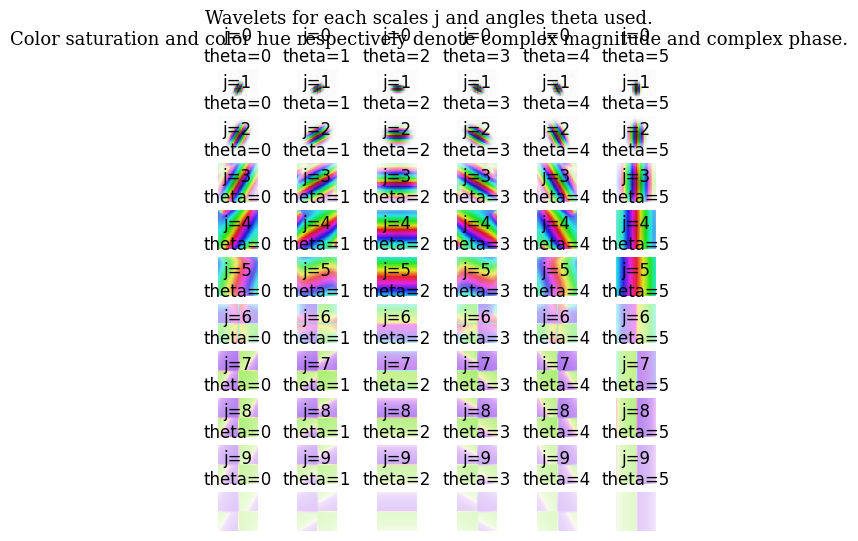

In [306]:
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
i = 0
for filter in filters_set['psi']:
    f = filter["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(
        "j={}\ntheta={}".format(i // L, i % L))
    i = i+1

fig.suptitle((r"Wavelets for each scales j and angles theta used."
              "\nColor saturation and color hue respectively denote complex "
              "magnitude and complex phase."), fontsize=13)
plt.tight_layout()
plt.show()

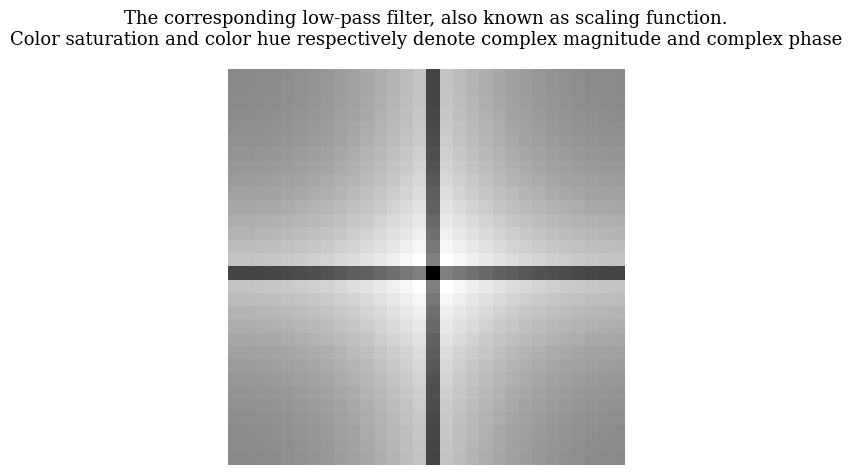

In [307]:
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi']["levels"][0]

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
plt.suptitle(("The corresponding low-pass filter, also known as scaling "
              "function.\nColor saturation and color hue respectively denote "
              "complex magnitude and complex phase"), fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

plt.tight_layout()
plt.show()

In [308]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D
import os

# Verifica esistenza immagine e caricamento
image_path = 'dog.jpg'
if not os.path.exists(image_path):
    raise FileNotFoundError(f"L'immagine {image_path} non esiste")

# Carica e prepara immagine
img = Image.open(image_path).convert('L')
target_size = (M, M)
img = img.resize(target_size)
x = torch.from_numpy(np.array(img)).float()
x = x.unsqueeze(0).unsqueeze(0)

# Configura Scattering2D
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scattering = Scattering2D(J=J, L=L, shape=target_size, max_order=2).to(device)
x = x.to(device)

# Calcola coefficienti
Sx = scattering(x)
print(Sx.size())

RuntimeError: The smallest dimension should be larger than 2^J.

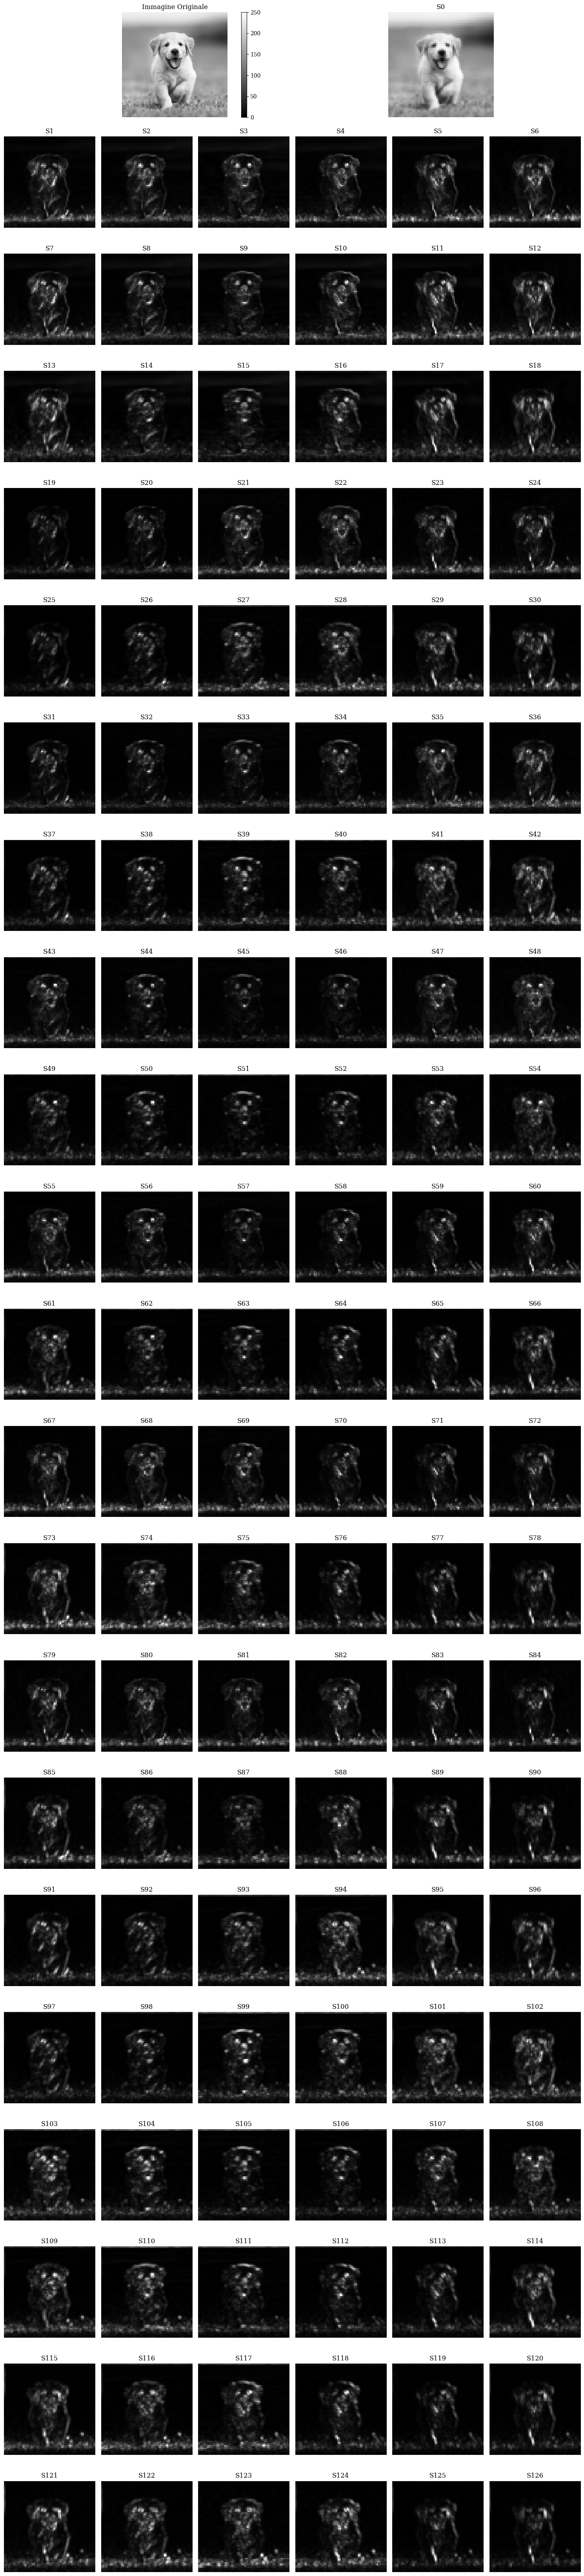

In [286]:
def plot_scattering_analysis(img, Sx, n_cols=L):
    """
    Visualizza scattering con layout modificato:
    - Prima riga: immagine originale e S0
    - Righe successive: altri coefficienti
    """
    n_scattering = len(Sx[0, 0])
    n_remaining = n_scattering - 1  # escluso S0
    n_rows = (n_remaining // n_cols) + (1 if n_remaining % n_cols != 0 else 0)
    
    # Imposta dimensioni figura
    plt.figure(figsize=(15, 3*(n_rows + 1)))
    
    # Prima riga: immagine originale e S0
    plt.subplot(n_rows + 1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title('Immagine Originale')
    plt.axis('off')
    
    plt.subplot(n_rows + 1, 2, 2)
    plt.imshow(Sx[0, 0][0].cpu().numpy(), cmap='gray')
    plt.title('S0')
    plt.axis('off')
    
    # Righe successive: altri coefficienti
    for i in range(1, n_scattering):
        plt.subplot(n_rows + 1, n_cols, n_cols + i)
        plt.imshow(Sx[0, 0][i].cpu().numpy(), cmap='gray')
        plt.title(f'S{i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo:
plot_scattering_analysis(img, Sx)

torch.Size([1, 127, 64, 64])


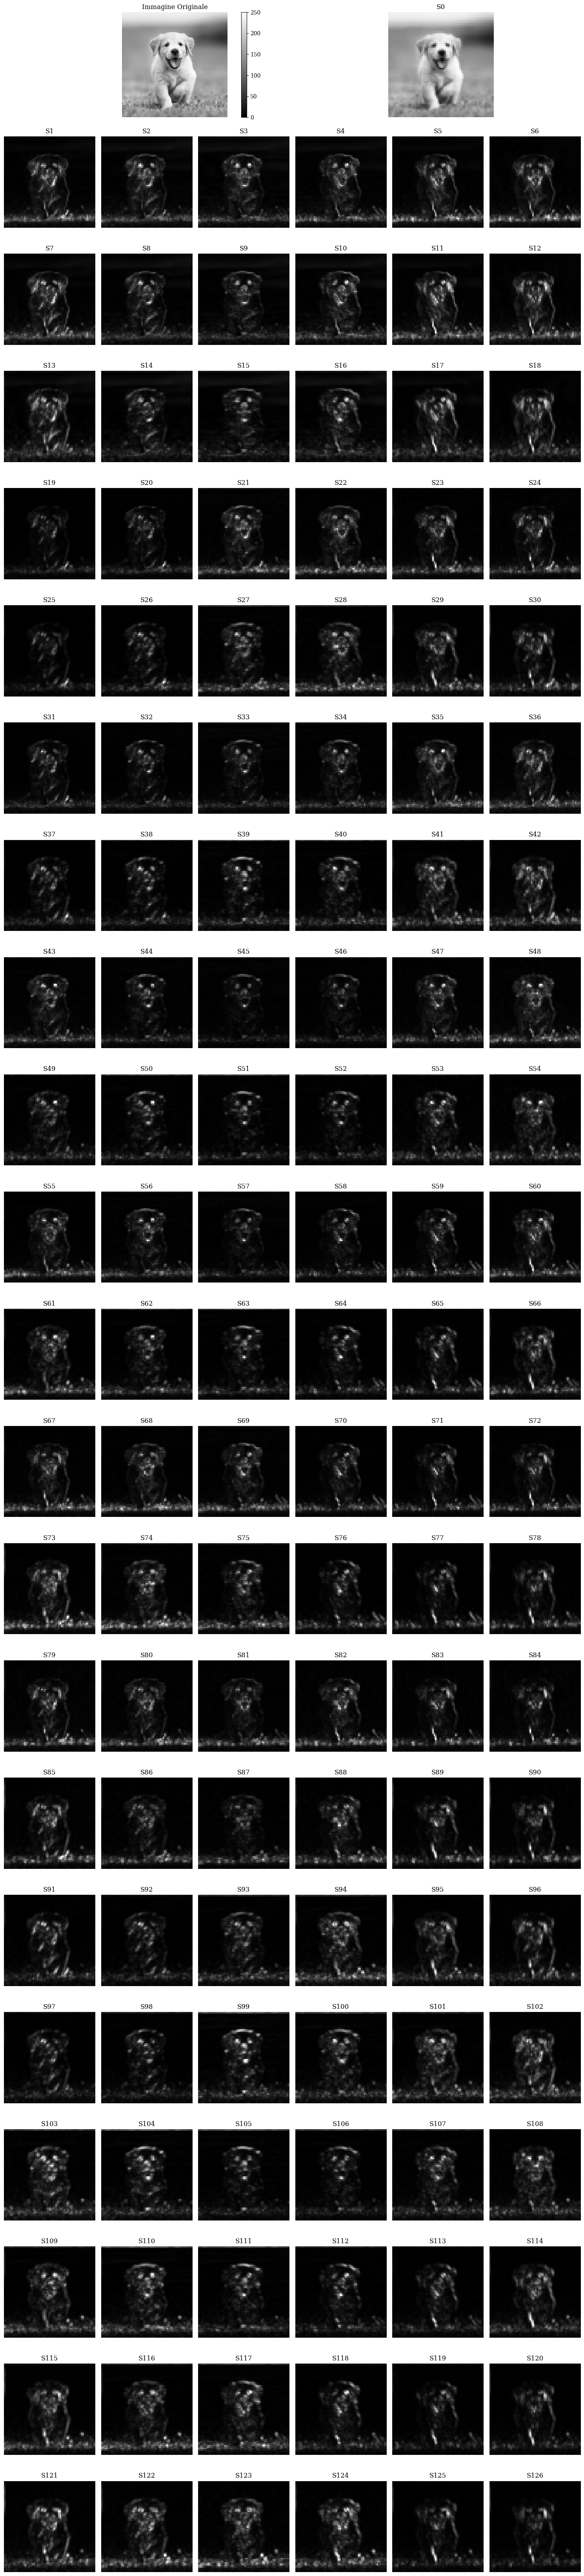

In [287]:
# what happend if x = torch.squeeze(x, 1) is used?

Sx2 = torch.squeeze(Sx, 1)
print(Sx2.size())

def plot_scattering_analysis(img, Sx, n_cols=L):
    """
    Visualizza scattering con layout modificato:
    - Prima riga: immagine originale e S0
    - Righe successive: altri coefficienti
    """
    n_scattering = len(Sx[0])
    n_remaining = n_scattering - 1  # escluso S0
    n_rows = (n_remaining // n_cols) + (1 if n_remaining % n_cols != 0 else 0)
    
    # Imposta dimensioni figura
    plt.figure(figsize=(15, 3*(n_rows + 1)))
    
    # Prima riga: immagine originale e S0
    plt.subplot(n_rows + 1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title('Immagine Originale')
    plt.axis('off')
    
    plt.subplot(n_rows + 1, 2, 2)
    plt.imshow(Sx[0][0].cpu().numpy(), cmap='gray')
    plt.title('S0')
    plt.axis('off')
    
    # Righe successive: altri coefficienti
    for i in range(1, n_scattering):
        plt.subplot(n_rows + 1, n_cols, n_cols + i)
        plt.imshow(Sx[0][i].cpu().numpy(), cmap='gray')
        plt.title(f'S{i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


plot_scattering_analysis(img, Sx2)

